In [1]:
from piscat.iPSF_model import ImagingSetupParameters
from PIL import Image
import os, shutil
from scipy import signal
import numpy as np
import scipy.ndimage as ndimage 
import math
import ipywidgets as widgets
from ipywidgets import interact
import matplotlib.pylab as plt
from piscat.iPSF_model.ScatteredFieldDifferentialPhase import ScatteredFieldDifferentialPhase
import sys
print(sys.executable)

/home/labadmin/miniconda3/envs/PiSCAT/bin/python


In [2]:
print(ImagingSetupParameters)

<module 'piscat.iPSF_model.ImagingSetupParameters' from '/home/labadmin/miniconda3/envs/PiSCAT/lib/python3.11/site-packages/piscat/iPSF_model/ImagingSetupParameters.py'>


In [10]:
p = ImagingSetupParameters
# Wavelength of the light source in meters
p.wavelength = 662e-9
# Numerical Aperture (NA) of the objective lens
p.NA = 1.4
# Thickness of the immersion oil, nominal value in meters
p.ti0 = 180e-6
# Refractive index of the immersion oil, nominal value
p.ni0 = 1.5
# Refractive index of the immersion oil, experimental value
p.ni = 1.5
# Thickness of the coverglass, nominal value in meters
p.tg0 = 170e-6
# Thickness of the coverglass, experimental value in meters
p.tg = 170e-6
# Refractive index of the coverglass, nominal value
p.ng0 = 1.5
# Refractive index of the coverglass, experimental value
p.ng = 1.5
# Refractive index of the sample/medium
p.ns = 1.33

subpixel_coef = 1

# Physical size of the camera pixel in meters
p.pixel_size_physical = 1.35e-6 / subpixel_coef #ispeed camera



# Imaging pixel size in meters, related to the physical pixel size through the magnification of the setup
pixel_size = 2.3e-9 / subpixel_coef #our 
# Magnification of the imaging system
p.M = p.pixel_size_physical / pixel_size


p.k0 = 2 * math.pi / p.wavelength   #Wavevector
p.alpha = math.asin(p.NA / p.ni)    #Largest angle collected by our Objective lens

depth = 200
depth_scale = 1

# The range across which the focus is swept
z_focus_array = np.arange(- depth//2, depth//2, 1) * pixel_size * depth_scale

# The 3D position of the nanoparticle
# Xp = [0, 0, depth / 2 * 4.524e-9 * depth_scale]
Xp = [0, 0, 0]

# Number of lateral pixels over which the image is calculated
nx = 512 * subpixel_coef + 1
# Number of lateral pixels over which the calculated image is cropped
r_ = 256 * subpixel_coef
# r_ = 512 * subpixel_coef
# r_ = 1024 * subpixel_coef + 1
nz = np.size(z_focus_array)


scattered_field = ScatteredFieldDifferentialPhase(p, Xp, z_focus_array, nz, nx)
scatteredFieldAmplitude_focalStack, scatteredFieldPhase_focalStack = scattered_field.calculate(r_)
iPSFs_focalStack = np.multiply(scatteredFieldAmplitude_focalStack, np.cos(scatteredFieldPhase_focalStack))
iPSFs_focalStack = iPSFs_focalStack / np.max(np.abs(iPSFs_focalStack[...]))
print("shape = " + str(iPSFs_focalStack.shape))

iPSFs_focalStack_meirdonal = iPSFs_focalStack[:,1+r_,:]
scatteredFieldAmplitude_focalStack_meirdonal = scatteredFieldAmplitude_focalStack[:,1+r_,:]
scatteredFieldPhase_focalStack_meirdonal = scatteredFieldPhase_focalStack[:,1+r_,:]

shape = (200, 513, 513)


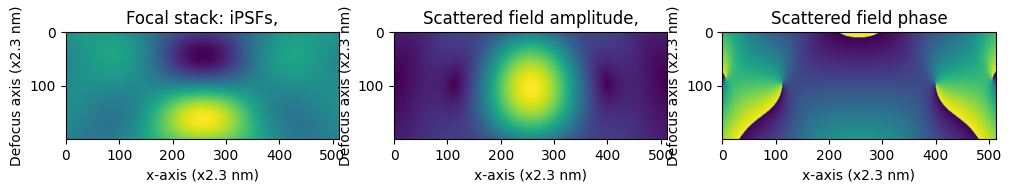

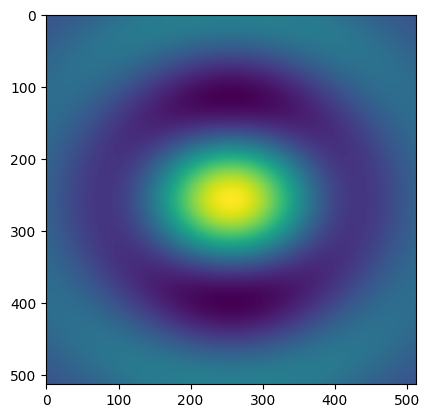

In [11]:
fig=plt.figure(figsize=(12,8), dpi=100, facecolor='w', edgecolor='k')

ax_1 = fig.add_subplot(131)
ax_1.imshow(iPSFs_focalStack_meirdonal)
ax_1.set_xlabel('x-axis (x' + str(pixel_size*1e9) + ' nm)')
ax_1.set_ylabel('Defocus axis (x' + str(pixel_size*1e9) + ' nm)')
ax_1.set_title('Focal stack: iPSFs,')

ax_2 = fig.add_subplot(132)
ax_2.imshow(scatteredFieldAmplitude_focalStack_meirdonal)
ax_2.set_xlabel('x-axis (x' + str(pixel_size*1e9) + ' nm)')
ax_2.set_ylabel('Defocus axis (x' + str(pixel_size*1e9) + ' nm)')
ax_2.set_title('Scattered field amplitude,')


ax_3 = fig.add_subplot(133)
ax_3.imshow(scatteredFieldPhase_focalStack_meirdonal)
ax_3.set_xlabel('x-axis (x' + str(pixel_size*1e9) + ' nm)')
ax_3.set_ylabel('Defocus axis (x' + str(pixel_size*1e9) + ' nm)')
ax_3.set_title('Scattered field phase')

# plt.savefig("z.png")
plt.show()
plt.close()

result = np.where(iPSFs_focalStack == iPSFs_focalStack.max())
focus = result[0][0]

plt.imshow(iPSFs_focalStack[focus,:,:])

In [4]:
def showPlots(arr, filename, ma, mi):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')

    sz = arr.shape
    
    result = np.where(arr == arr.min())
    focus = 32#result[0][0]
    print("focus = " + str(focus))

    ax_1 = fig.add_subplot(131)
    ax_1.imshow(arr[:, int(sz[1] / 2), :], vmax = ma, vmin=mi)

    ax_2 = fig.add_subplot(132)
    ax_2.imshow(arr[:, :, int(sz[2] / 2)], vmax = ma, vmin=mi)

    ax_3 = fig.add_subplot(133)
    im = ax_3.imshow(arr[focus, :, :], vmax = ma, vmin=mi)
    divider = make_axes_locatable(ax_3)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    # plt.savefig(filename)
    plt.title(filename[:-3])
    plt.show()
    plt.close()

def slice(arr, folder):
    
    try:
        shutil.rmtree(folder)
    except:
        print("creating folder")
    os.mkdir(folder)

    maxval = arr.max()
    minval = arr.min()

    result = np.where(arr == maxval)
    focus = result[0][0]
    print("focus1 = " + str(focus))

    result = np.where(arr == minval)
    focus = result[0][0]
    print("focus2 = " + str(focus))

    ran = list(map(lambda x: np.sign(x)*x*x + focus, range(-5,6)))
    print("range = " + str(ran))
    for z in ran:
        if z >= 0 and z < arr.shape[0]:
            slice = arr[z, :, :]
            I8 = (((slice - minval) / (maxval - minval)) * 255.9).astype(np.uint8)

            img = Image.fromarray(I8)
            # img.save(folder + "/slice" + str(z) + ".png")



In [5]:
sz = iPSFs_focalStack.shape
#glass roughness 
surfaceSZ = (sz[1]*2 , sz[2]*2)

#povrchval = np.random.sample((sz[1], sz[2])) * 3
expectedValue = .51
variation = .1
povrchval = np.random.lognormal(expectedValue, variation, surfaceSZ)
povrchval[povrchval > 1000] = expectedValue

povrchval = povrchval / povrchval.max()

In [6]:
focus

715

In [7]:
sz = iPSFs_focalStack.shape


#cylinder

cyl = np.zeros((sz[0], sz[1] * 2, sz[2]* 2))
cyl1 = np.zeros((sz[0], sz[1] * 2, sz[2]* 2))
part = np.zeros((sz[0], sz[1] * 2, sz[2]* 2))
sz = cyl.shape
# print("shape of cyl = " + str(cyl.shape))
result = np.where(iPSFs_focalStack == iPSFs_focalStack.min())
focus = result[0][0]

startz = 11#int(sz[0] / 2)
starty = int(sz[2] / 2)
cyl_cont =10
part_const=100
# for x in range(0, sz[1]):
#     cyl[startz, x, starty] = 1
# cyl[startz, 0:sz[1], starty] = cyl_cont    
# cyl[50, 100, 55] = 10

cyl1[startz, 60:-60, starty] = cyl_cont  
cyl1[startz, 60:-60, starty+1] = cyl_cont  
cyl1[startz+1, 60:-60, starty] = cyl_cont  
cyl1[startz+1, 60:-60, starty+1] = cyl_cont  
# cyl1[startz] = ndimage.rotate(cyl1[startz], 10, axes=(1, 0), reshape=False, output=None, order=3, mode='constant', cval=0.0, prefilter=False)
# part[startz, int(sz[1]/2), starty] = part_const
# cyl1[startz, 200, starty] = part_const*5
# cyl1[50, 100, 53] = part_const/2
# cyl1[50, 120, 70] = part_const
# cyl1[30, 75, 60] = part_const
def f(shx=20.20,  sh=20, gf=3, shY=0, shZ=0): #shy=1, shz=0,
    global con_cyl_NP
    cyl2=np.copy(cyl1)
    # startz=shZ
    cyl2[startz, 200, starty] += part_const*10*(1-shY)*shZ
    cyl2[startz, 200, starty+1] += part_const*10*(shY)*shZ
    cyl2[startz+1, 200, starty] += part_const*10*(1-shY)*(1-shZ)
    cyl2[startz+1, 200, starty+1] += part_const*10*(shY)*(1-shZ)
    plt.close('all')    
    fig = plt.figure(figsize=(18, 20))
    ax = fig.add_subplot(3, 1, 1)
    # cyl2 = ndimage.rotate(ndimage.shift(part, [shz,shx,shy], output=None, order=3, mode='constant', cval=0.0, prefilter=False)+cyl1, 80,
    #                       axes=(1, 2), reshape=False, output=None, order=3, mode='constant', cval=0.0, prefilter=False)
    # cyl3 = ndimage.shift(cyl2, [shz,shx,shy], output=None, order=1, mode='constant', cval=0.0, prefilter=False)
    # for deg in range(20,180,20):
    #     cyl2 += ndimage.rotate(cyl3, deg,
    #                       axes=(1, 2), reshape=False, output=None, order=5, mode='constant', cval=0.0, prefilter=False)    
    cyl2[startz-1]+=80*povrchval
    #convolution

    # con_cyl = signal.convolve(cyl, iPSFs_focalStack, mode='same')
    # print("shape of convoluted = " + str(con_cyl.shape))
    con_cyl_NP = signal.convolve(cyl2, iPSFs_focalStack, mode='same')
    # con_NP = signal.convolve(part, iPSFs_focalStack, mode='same')
    #results
    ma = con_cyl_NP.max()
    mi = con_cyl_NP.min()
    armi= np.where(con_cyl_NP == mi)#np.amin(con_cyl_NP))
    ax.imshow(con_cyl_NP[33, 180:-180, 180:-180],cmap='gray')#armi[0][0
    print(con_cyl_NP[33, 180:-180, 180:-180].min())
    ax1 = fig.add_subplot(3, 1, 2)
    ax1.imshow(ndimage.gaussian_filter((ndimage.shift(con_cyl_NP[33, :, :], [0,sh], output=None, order=1, mode='constant',
                                                      cval=0.0, prefilter=False)-con_cyl_NP[33, :, :])[30:-30,30:-30], gf),cmap='gray')
    ax2 = fig.add_subplot(3, 1, 3)  
    result = np.where(cyl2 == cyl2.max())
    focus1 = result[0][0]
    ax2.imshow(cyl2[11, 180:-180, 180:-180])#,cmap='gray')#, aspect = 'auto')
    
    plt.close('all')
    print(focus1)
    return fig
interact(f, shx=widgets.FloatSlider(min=-50,max=500,step=.001,value=0., continuous_update=False),
        # shy=widgets.FloatSlider(min=-50,max=50,step=.001,value=0., continuous_update=False),
        # shz=widgets.FloatSlider(min=-50,max=50,step=.001,value=0., continuous_update=False),
        sh=widgets.FloatSlider(min=0,max=50,step=.01,value=2., continuous_update=False),
        shY=widgets.FloatSlider(min=0,max=1,step=.01,value=0., continuous_update=False),
        shZ=widgets.FloatSlider(min=0,max=1,step=.1,value=0, continuous_update=False),
        gf=widgets.FloatSlider(min=0,max=10,step=.01,value=1., continuous_update=False))     
# plt.imshow(iPSFs_focalStack)

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='shx', max=500.0, min=-50.0,…

<function __main__.f(shx=20.2, sh=20, gf=3, shY=0, shZ=0)>

In [7]:
shx=0
sh=2
        # shY=widgets.FloatSlider(min=0,max=1,step=.01,value=0., continuous_update=False),
        # shZ=widgets.FloatSlider(min=0,max=1,step=.1,value=0, continuous_update=False),
        # gf=widgets.FloatSlider(min=0,max=10,step=.01,value=1., continuous_update=False))    
image=[]
shifted=[]
gt=[]
for pos in positions:
    shY=pos[0]
    shZ=pos[1]
    gf=0.01
    cyl2=np.copy(cyl1)
    # startz=shZ
    cyl2[startz, 200, starty] += part_const*10*(1-shY)*shZ
    cyl2[startz, 200, starty+1] += part_const*10*(shY)*shZ
    cyl2[startz+1, 200, starty] += part_const*10*(1-shY)*(1-shZ)
    cyl2[startz+1, 200, starty+1] += part_const*10*(shY)*(1-shZ)
    plt.close('all')    
    fig = plt.figure(figsize=(18, 20))
    ax = fig.add_subplot(3, 1, 1)

    cyl2[startz-1]+=80*povrchval
    #convolution

    # con_cyl = signal.convolve(cyl, iPSFs_focalStack, mode='same')
    # print("shape of convoluted = " + str(con_cyl.shape))
    con_cyl_NP = signal.convolve(cyl2, iPSFs_focalStack, mode='same')
    # con_NP = signal.convolve(part, iPSFs_focalStack, mode='same')
    #results
    ma = con_cyl_NP.max()
    mi = con_cyl_NP.min()
    armi= np.where(con_cyl_NP == mi)#np.amin(con_cyl_NP))
    ax.imshow(con_cyl_NP[33, 180:-180, 180:-180],cmap='gray')#armi[0][0
    image.append(con_cyl_NP[33])
    print(con_cyl_NP[33, 180:-180, 180:-180].min())
    ax1 = fig.add_subplot(3, 1, 2)
    ax1.imshow(ndimage.gaussian_filter((ndimage.shift(con_cyl_NP[33, :, :], [0,sh], output=None, order=1, mode='constant',
                                                      cval=0.0, prefilter=False)-con_cyl_NP[33, :, :])[30:-30,30:-30], gf),cmap='gray')
    shifted.append(ndimage.gaussian_filter((ndimage.shift(con_cyl_NP[33, :, :], [0,sh], output=None, order=1, mode='constant',
                                                      cval=0.0, prefilter=False)-con_cyl_NP[33, :, :])[30:-30,30:-30], gf))
    ax2 = fig.add_subplot(3, 1, 3)  
    result = np.where(cyl2 == cyl2.max())
    focus1 = result[0][0]
    ax2.imshow(cyl2[11, 180:-180, 180:-180])#,cmap='gray')#, aspect = 'auto')
    gt.append(cyl2[11])
    plt.show()
    plt.close()
    

NameError: name 'cyl1' is not defined

In [88]:
import skimage

skimage.io.imsave('E:\image.tiff',np.array(image) )
skimage.io.imsave('E:\shifted.tiff',np.array(shifted) )
skimage.io.imsave('E:\gt.tiff',np.array(gt ))

C:\Users\bujak\AppData\Local\Temp\ipykernel_21180\4082294084.py:5: UserWarning: E:\gt.tiff is a low contrast image
  skimage.io.imsave('E:\gt.tiff',np.array(gt ))


In [65]:
result = np.where(cyl2 == cyl2.max())
focus1 = result[0][0]

NameError: name 'cyl2' is not defined

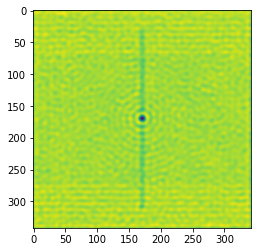

In [27]:
plt.imshow(tt1+tt2)

In [6]:
import math

a = 0
b = 0
r = 1

#The lower this value the higher quality the circle is with more points generated
stepSize = 0.120

#Generated vertices
positions = []

t = 0
while t <  math.pi/2:
    positions.append((r * math.cos(t) + a, r * math.sin(t) + b))
    t += stepSize

print((positions))

[(1.0, 0.0), (0.9928086358538663, 0.11971220728891936), (0.9713379748520296, 0.23770262642713458), (0.9358968236779348, 0.35227423327508994), (0.8869949227792842, 0.46177917554148284), (0.8253356149096783, 0.5646424733950354), (0.751805729140895, 0.6593846719714731), (0.6674628258413081, 0.7446431199708593), (0.5735199860724567, 0.8191915683009983), (0.47132836417373997, 0.8819578068849475), (0.3623577544766734, 0.9320390859672264), (0.24817545165237268, 0.9687151001182653), (0.1304237087381451, 0.9914583481916865), (0.010796117058266948, 0.9999417202299663)]


In [84]:
points = positions
ss=len(points)
sz = iPSFs_focalStack.shape
res = np.zeros((ss, tt1.shape[0], tt1.shape[1]))
for i,dd in enumerate(points):
    res[i]=dd[0]*tt0+(1-dd[0])*tt3+tt1*(dd[1])+tt2*(1-dd[1])

In [50]:
points =np.arange(0,1,0.01)
ss=len(points)
sz = iPSFs_focalStack.shape
res = np.zeros((ss, tt1.shape[0], tt1.shape[1]))
for i,dd in enumerate(points):
    res[i]=dd*tt1+(1-dd)*tt2

In [87]:
import skimage
skimage.io.imsave('test1.tiff', res[:,:,1:]-res[:,:,:-1])

In [10]:


import torch
from fft_conv_pytorch import fft_conv, FFTConv3d
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
sz = iPSFs_focalStack.shape
cyl = np.zeros((sz[0], sz[1] , sz[2]))
cyl1 = np.zeros((sz[0], sz[1] * 2, sz[2]* 2))
part = np.zeros((sz[0], sz[1] * 2, sz[2]* 2))
sz = cyl.shape
# print("shape of cyl = " + str(cyl.shape))
result = np.where(iPSFs_focalStack == iPSFs_focalStack.min())
focus = result[0][0]

startz = int(sz[0] / 2)
starty = int(sz[2] / 2)
cyl_cont =1
part_const=9
# for x in range(0, sz[1]):
#     cyl[startz, x, starty] = 1
# cyl[startz, 0:sz[1], starty] = cyl_cont    
# cyl[50, 100, 55] = 10

cyl[startz, 60:int(sz[1] / 2), starty] = cyl_cont  
signal = torch.from_numpy(cyl).float().to(device)
kernel = torch.from_numpy(iPSFs_focalStack).float().to(device)
bias =  torch.randn(sz[0]).float().to(device)
# out = torch.nn.functional.conv3d(signal, kernel)

# out = fft_conv(signal, kernel, bias=bias)
fft_conv = FFTConv3d(sz[0], sz[0], (sz[0],sz[1],sz[2]), bias=False)
fft_conv.weight = torch.nn.Parameter(kernel)
out = fft_conv(signal)
plt.imshow(out.to('cpu'),cmap='gray')

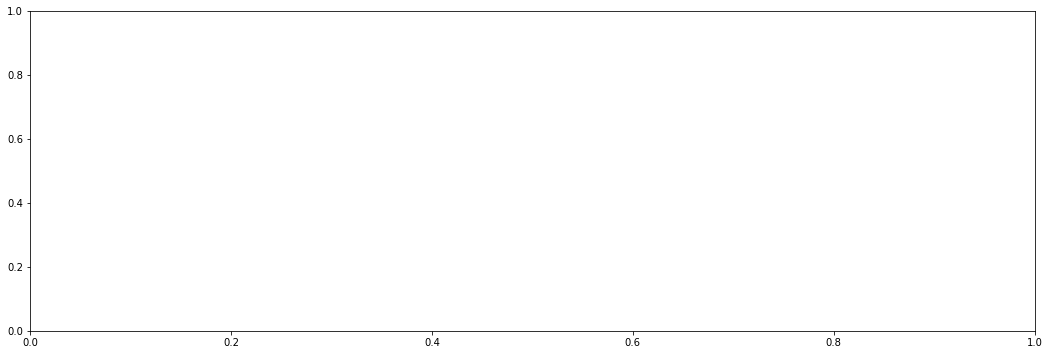

In [19]:
import ray
# folder = r'd:\shifts'
# # try:
# #     shutil.rmtree(folder)
# # except:
# #     print("creating folder")
# # os.mkdir(folder)
# sz = iPSFs_focalStack.shape
# #glass roughness 
# surfaceSZ = (sz[1]*2 , sz[2]*2)

# #povrchval = np.random.sample((sz[1], sz[2])) * 3
# expectedValue = .51
# variation = .1
# povrchval = np.random.lognormal(expectedValue, variation, surfaceSZ)
# povrchval[povrchval > 1000] = expectedValue

# povrchval = povrchval / povrchval.max()


# #cylinder

# cyl = np.zeros((sz[0], sz[1] * 2, sz[2]* 2))
# cyl1 = np.zeros((sz[0], sz[1] * 2, sz[2]* 2))
# part = np.zeros((sz[0], sz[1] * 2, sz[2]* 2))
# sz = cyl.shape
# # print("shape of cyl = " + str(cyl.shape))
# result = np.where(iPSFs_focalStack == iPSFs_focalStack.min())
# focus = result[0][0]

# startz = int(sz[0] / 2)
# starty = int(sz[2] / 2)
# cyl_cont =1
# part_const=9


# cyl1[startz, 60:int(sz[1] / 2), starty] = cyl_cont  

shy=0
shz=0
sh=2
gf=1
for shx in np.arange(-25, -24, 1/45.24):    
    cyl2=np.copy(cyl1)
    plt.close('all')    
    fig = plt.figure(figsize=(18, 20))
    ax = fig.add_subplot(3, 1, 1)
    # cyl2 = ndimage.rotate(ndimage.shift(part, [shz,shx,shy], output=None, order=3, mode='constant', cval=0.0, prefilter=False)+cyl1, 80,
    #                       axes=(1, 2), reshape=False, output=None, order=3, mode='constant', cval=0.0, prefilter=False)
    cyl3 = ndimage.shift(cyl2, [shz,shx,shy], output=None, order=1, mode='constant', cval=0.0, prefilter=False)
    for deg in range(20,180,20):
        cyl2 += ndimage.rotate(cyl3, deg,
                          axes=(1, 2), reshape=False, output=None, order=1, mode='constant', cval=0.0, prefilter=False)    
    cyl2[34]+=5*povrchval
    #convolution

    # con_cyl = signal.convolve(cyl, iPSFs_focalStack, mode='same')
    # print("shape of convoluted = " + str(con_cyl.shape))
    con_cyl_NP = signal.convolve(cyl2, iPSFs_focalStack, mode='same')[33, 30:-30, 30:-30]
    con_cyl_NP /= con_cyl_NP.mean()
    con_cyl_NPSH = ndimage.gaussian_filter((ndimage.shift(con_cyl_NP, [0,sh], output=None, order=1, mode='constant',
                                                      cval=0.0, prefilter=False)-con_cyl_NP), gf)
    con_cyl_NP *= 55000
    con_cyl_NPSH += 1
    con_cyl_NPSH *= 55000
    
    # print(con_cyl_NP.max())
    # print(con_cyl_NP.min())
    I16 = con_cyl_NP.astype(np.uint16)
    img = Image.fromarray(I16)
    img.save(folder + "/shift-Conv" + str(shx) + ".png")
    I16 = con_cyl_NPSH.astype(np.uint16)
    img = Image.fromarray(I16)
    img.save(folder + "/shift-Moved" + str(shx) + ".png")  
    kk = cyl2[startz, 30:-30, 30:-30]/cyl2[startz, 30:-30, 30:-30].mean()
    kk*=55000
    I16 = kk.astype(np.uint16)
    img = Image.fromarray(I16)
    img.save(folder + "/shift-Org" + str(shx) + ".png")      

In [6]:
#result = ndimage.zoom(iPSFs_focalStack, (1,40,40.0), order=1)

In [7]:
iPSFs_focalStack.shape

(100, 201, 201)

In [8]:
result.shape

AttributeError: 'tuple' object has no attribute 'shape'

In [ ]:
plt.imshow(iPSFs_focalStack[35])

con_cyl_NP = signal.convolve(cyl1[50], iPSFs_focalStack[35], mode='same')
plt.imshow(con_cyl_NP.T)

In [ ]:
# showPlots(cyl, "cylinder.png", ma, mi)
# showPlots(iPSFs_focalStack, "psf.png", ma, mi)
# showPlots(con_cyl, "con_cyl.png", ma, mi)
# showPlots(con_NP, "con_NP.png", ma, mi)
showPlots(con_cyl_NP, "con_cylNP.png", ma, mi)
# showPlots((con_cyl_NP/con_cyl), "(cylNP-con_cyl).png", ma, mi)
#slice PSF
# slice(iPSFs_focalStack, "slicesPT")

#slice convoluted
# slice(con_cyl, "slicesMT")

In [ ]:
plt.imshow(con_cyl_NP[23, :, :].T)